In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import mlflow

import logging
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.metrics import r2_score, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import sys
from datetime import datetime

### Load Dataset

In [2]:
logging.info('Load Training Set')

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_column', None)
df_train = pd.read_csv('../data/train_final.csv', na_values=['?', None, 'undefined'])
df_train = df_train.reindex(index=df_train.index[::-1])
df_train.head()

,Store,DayOfWeek,Open,Promo,Holiday,SchoolHoliday,Day,Month,Year,Weekend,TimeOfMonth,7DayStore,StoreType,Assortment,CompetitionDistance,Promo2,TillHday,AfterHday,Sales
1017208,1115,2,0,0,2,1,1,1,2013,0,0,0,3,2,5350.0,1,0,5,0
1017207,1114,2,0,0,2,1,1,1,2013,0,0,0,0,2,870.0,0,0,5,0
1017206,1113,2,0,0,2,1,1,1,2013,0,0,0,0,2,9260.0,0,0,5,0
1017205,1112,2,0,0,2,1,1,1,2013,0,0,0,2,2,1880.0,0,0,5,0
1017204,1111,2,0,0,2,1,1,1,2013,0,0,0,0,0,1900.0,1,0,5,0


In [4]:
logging.info('Load Test Set')

In [5]:
df_test = pd.read_csv('../data/test_final.csv', na_values=['?', None, 'undefined'])
df_test = df_test.reindex(index=df_test.index[::-1])
df_test.head()

,Store,DayOfWeek,Open,Promo,Holiday,SchoolHoliday,Day,Month,Year,Weekend,TimeOfMonth,7DayStore,StoreType,Assortment,CompetitionDistance,Promo2,TillHday,AfterHday
41076,1115,6,1.0,0,1,1,1,8,2015,1,0,0,3,2,5350.0,1,14,14
41075,1114,6,1.0,0,1,0,1,8,2015,1,0,0,0,2,870.0,0,14,14
41074,1113,6,1.0,0,1,0,1,8,2015,1,0,0,0,2,9260.0,0,14,14
41073,1112,6,1.0,0,1,0,1,8,2015,1,0,0,2,2,1880.0,0,14,14
41072,1111,6,1.0,0,1,0,1,8,2015,1,0,0,0,0,1900.0,1,14,14


### Check whether your time Series Data is Stationary

In [6]:
sales = df_train['Sales'].values
split = len(sales) // 2
X1, X2 = sales[0:split], sales[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5648.631594, mean2=5899.006105
variance1=14290518.018749, variance2=15321971.236433


The data is not statonary because the **means** and **variances** are significantly different

###  Autocorrelation and partial autocorrelation

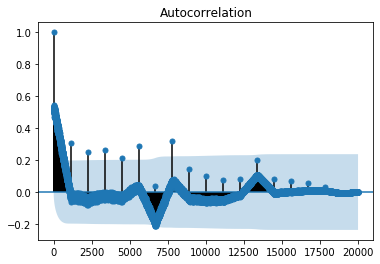

In [7]:
plot_acf(sales[:20000])
plt.show()

The Pearson’s correlation coefficient is a number between -1 and 1 that describes a negative or positive correlation respectively. A value of zero indicates no correlation.

We can calculate the correlation for time series observations with observations with previous time steps, called lags. Because the correlation of the time series observations is calculated with values of the same series at previous times, this is called a serial correlation, or an autocorrelation.

A plot of the autocorrelation of a time series by lag is called the AutoCorrelation Function, or the acronym ACF. This plot is sometimes called a correlogram or an autocorrelation plot.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

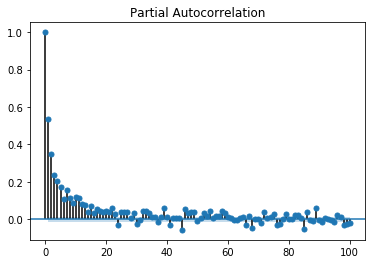

In [8]:
plot_pacf(sales[:20000], lags=100)
plt.show()

A partial autocorrelation is a summary of the relationship between an observation in a time series with observations at prior time steps with the relationships of intervening observations removed.

The autocorrelation for an observation and an observation at a prior time step is comprised of both the direct correlation and indirect correlations. These indirect correlations are a linear function of the correlation of the observation, with observations at intervening time steps.

It is these indirect correlations that the partial autocorrelation function seeks to remove. Without going into the math, this is the intuition for the partial autocorrelation.

### Scale Data

In [41]:
X = df_train[df_train['Store'] == 16].values[:10000]


sc_x = StandardScaler()

X = sc_x.fit_transform(X)
y = np.array(X[:,[-1]][7:])

#X = np.reshape(X, (941, 1, 1))
X.shape, y.shape

((942, 19), (935, 1))

In [42]:
def window(array, size):
    l = []
    for i in range(len(array)-size):
        l.append(array[i:i+size])
    return np.array(l)
X = window(X,7)
X.shape

(935, 7, 19)

### Train Test Split

In [43]:
ind = int(len(X)*95/100)
X_train, X_test, y_train, y_test = X[:ind], X[ind:], y[:ind], y[ind:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((888, 7, 19), (47, 7, 19), (888, 1), (47, 1))

## Window Dataset

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 7, 20)             3200      
_________________________________________________________________
lstm_14 (LSTM)               (None, 10)                1240      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 4,451
Trainable params: 4,451
Non-trainable params: 0
_________________________________________________________________


### Train Model

In [44]:
regressor = Sequential()

regressor.add(LSTM(20, activation = 'sigmoid', return_sequences=True, input_shape = (7, 19)))
regressor.add(LSTM(10))
regressor.add(Dense(1))

regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

regressor.fit(X_train, y_train, batch_size = 7, epochs = 30)

Epoch 1/30
888/888 [==============================] - 4s 4ms/sample - loss: 0.9964
Epoch 2/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.9290
Epoch 3/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.6167
Epoch 4/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.3825
Epoch 5/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.3029
Epoch 6/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.2814
Epoch 7/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.2719
Epoch 8/30
888/888 [==============================] - 1s 2ms/sample - loss: 0.2580
Epoch 9/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.2553
Epoch 10/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.2498
Epoch 11/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.2509
Epoch 12/30
888/888 [==============================] - 1s 1ms/sample - loss: 0.2517
E

### Test Model

r2 score: 0.9039739585840261
mean squared error: 0.09072634536902094


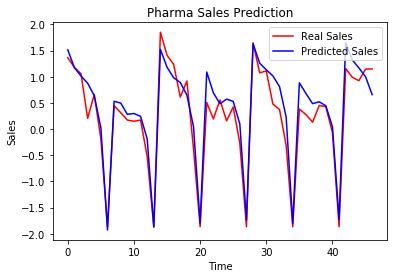

In [49]:

y_pred = regressor.predict(X_test)
#predicted_price = sc.inverse_transform(predicted_price)

print('r2 score:', r2_score(y_test, y_pred))
print('mean squared error:', mean_squared_error(y_test, y_pred))

plt.plot(y_test, color = 'red', label = 'Real Sales')
plt.plot(y_pred, color = 'blue', label = 'Predicted Sales')
plt.title('Pharma Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()


In [47]:
print(X_test[1], y_pred[0], y_test[0])

[[ 0.00000000e+00 -1.00026719e+00  4.60820152e-01 -7.86483758e-01
   1.89483396e-01 -4.43790992e-01 -7.63046016e-01  1.14127718e-02
   1.51830931e+00 -6.30576017e-01 -1.23656490e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.42410548e-01 -9.51332484e-01  2.67529623e-01]
 [ 0.00000000e+00 -4.99602105e-01  4.60820152e-01 -7.86483758e-01
   1.89483396e-01 -4.43790992e-01 -6.49277522e-01  1.14127718e-02
   1.51830931e+00 -6.30576017e-01 -1.23656490e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.42410548e-01 -9.13432074e-01  3.81596621e-01]
 [ 0.00000000e+00  1.06298320e-03  4.60820152e-01 -7.86483758e-01
   1.89483396e-01 -4.43790992e-01 -5.35509027e-01  1.14127718e-02
   1.51830931e+00 -6.30576017e-01 -1.55542754e-02  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -5.42410548e-01 -8.75531664e-01  3.75996433e-01]
 [ 0.00000000e+00  5.01728072e-01  4.60820152e-01 -7.86

### Save Model

In [28]:
regressor.save("../models/lstm_model.h5")